## Skin Cancer Detection - Multiclass Classification using CNN

Detecting skin cancer, particularly melanoma, is a critical task in the medical field. Melanoma accounts for 75% of skin cancer deaths and early detection is crucial for successful treatment. This project aims to build a Convolutional Neural Network (CNN) model that can accurately detect skin cancer from images, helping dermatologists identify potential cases more efficiently and reducing the need for manual diagnosis.

In [1]:
# Importing Required Libraries
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

In [2]:
# If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
# drive.mount('/content/gdrive')

# Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining Train and Test Paths
data_dir_train = pathlib.Path("./Data/Train")
data_dir_test = pathlib.Path("./Data/Test")

In [4]:
# Checking Dataset Size
image_count_train = len(list(data_dir_train.glob("*/*.jpg")))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob("*/*.jpg")))
print(image_count_test)

2239
118


In [5]:
# Hyperparameters
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Creating Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 80% Training Data and 20% Validation Data
    subset="training",  # Training Set
    seed=123,
    image_size=(img_height, img_width),  # Resizing Image
    batch_size=batch_size,
)

Found 2240 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",  # Validation Set
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2240 files belonging to 9 classes.
Using 448 files for validation.


In [8]:
# Listing out Classes ( Taken from Folder names, Check Data Folders for understanding )
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

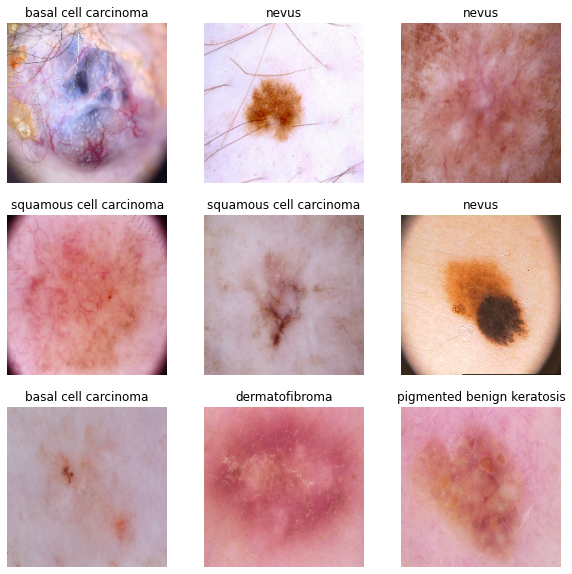

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(num_classes):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [10]:
for image_batch, labels_batch in train_ds.take(1):
    print("Image Batch Shape", image_batch.shape)
    print("Batch Label Shape:", labels_batch.shape)
    break

Image Batch Shape (32, 180, 180, 3)
Batch Label Shape: (32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
model = Sequential(
    [
        layers.Rescaling(
            scale=1.0 / 225,
            input_shape=(img_height, img_width, 3),
            name="Input_Rescaling",
        ),
        layers.Conv2D(
            filters=16,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="ConvHLayer-1",
        ),
        layers.MaxPooling2D(name="MaxPoolHLayer-1"),
        layers.Conv2D(
            filters=32,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="ConvHLayer-2",
        ),
        layers.MaxPooling2D(name="MaxPoolHLayer-2"),
        layers.Conv2D(
            filters=64,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="ConvHLayer-3",
        ),
        layers.MaxPooling2D(name="MaxPoolHLayer-3"),
        layers.Flatten(name="Flatten-4"),
        layers.Dense(units=128, activation="relu", name="DenseHLayer-5"),
        layers.Dense(units=num_classes, name="Output"),
    ]
)

In [13]:
model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Rescaling (Rescaling)  (None, 180, 180, 3)      0         
                                                                 
 ConvHLayer-1 (Conv2D)       (None, 180, 180, 16)      448       
                                                                 
 MaxPoolHLayer-1 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 ConvHLayer-2 (Conv2D)       (None, 90, 90, 32)        4640      
                                                                 
 MaxPoolHLayer-2 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 ConvHLayer-3 (Conv2D)       (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 18s 211ms/step - loss: 1.8507 - accuracy: 0.3331 - val_loss: 1.7948 - val_accuracy: 0.3125
Epoch 2/20
56/56 [==============================] - 8s 148ms/step - loss: 1.6509 - accuracy: 0.4135 - val_loss: 1.6575 - val_accuracy: 0.3884
Epoch 3/20
56/56 [==============================] - 8s 149ms/step - loss: 1.4653 - accuracy: 0.4838 - val_loss: 1.4458 - val_accuracy: 0.5000
Epoch 4/20
56/56 [==============================] - 8s 149ms/step - loss: 1.2850 - accuracy: 0.5530 - val_loss: 1.4025 - val_accuracy: 0.5246
Epoch 5/20
56/56 [==============================] - 8s 149ms/step - loss: 1.1654 - accuracy: 0.5910 - val_loss: 1.3315 - val_accuracy: 0.5379
Epoch 6/20
56/56 [==============================] - 8s 150ms/step - loss: 1.0644 - accuracy: 0.6278 - val_loss: 1.4336 - val_accuracy: 0.5268
Epoch 7/20
56/56 [==============================] - 8s 150ms/step - loss: 0.9520 - accuracy: 0.6680 - val_loss: 1.3532 - val_accuracy: 0.5536
Epoch

### Visualizing training results

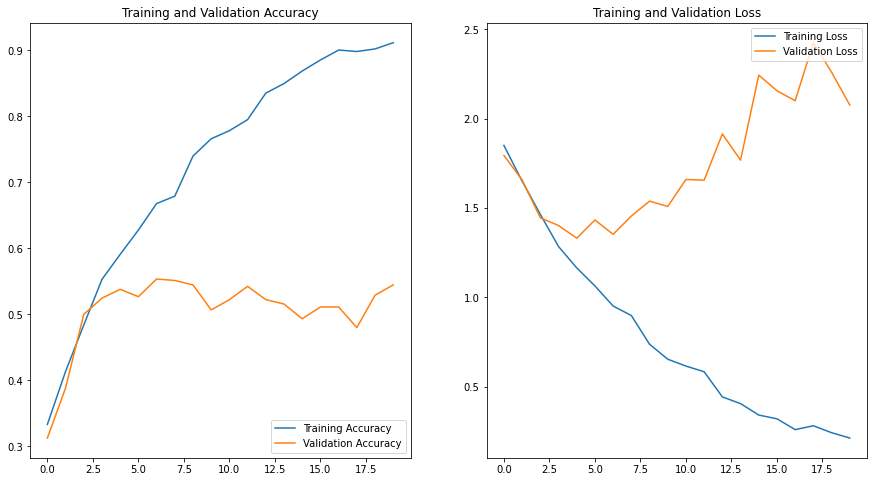

In [16]:
acc = history.history["accuracy"]  # List of Historical Train Set Accuracies
val_acc = history.history["val_accuracy"]  # List of Historical Validation Accuracies

loss = history.history["loss"]  # List of Historical Train Set Loss
val_loss = history.history["val_loss"]  # List of Historical Train Set Loss

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

From the above graph we observe that there is a huge gap between training and validation accuracy. Furthermore, the validaton loss also increase after the 7th epoch.

This clearly shows we have overfit the model to our data.

To tackle overfitting, we can
- Increase training size
- Decrease model complexity / features
- Increase Regularization 

Let us Increase the training size using Data Augmentation and use dropouts to increase regularization to address overfitting

In [17]:
data_augmenter = Sequential(
    [
        layers.RandomFlip(
            mode="horizontal_and_vertical",  # Flip Images Horizontal and Vertically
            input_shape=(img_height, img_width, 3),
        ),
        layers.RandomRotation(0.1),  # Randomly Rotate by factor of 0.1
        layers.RandomZoom(0.1),  # Randomly Zoom by factor of 0.1
    ],
    name="data_augmenter",
)

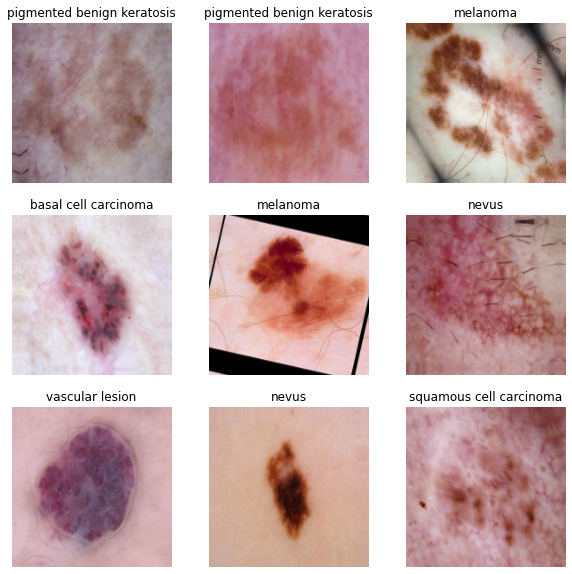

In [18]:
# Visualising Augmented Images

plt.figure(figsize=(10, 10))
for images, lables in train_ds.take(1):
    augmented_images = data_augmenter(images)
    for i in range(num_classes):
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[lables[i]])
        plt.axis("off")

In [19]:
model2 = Sequential(
    [
        data_augmenter,  # Data Augmentation Before Model
        layers.Rescaling(scale=1.0 / 255, name="Input_Rescaling"),
        layers.Conv2D(
            filters=16,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv2DH-1",
        ),
        layers.MaxPooling2D(name="MaxPoolH-1"),
        layers.Conv2D(
            filters=32,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv2DH-2",
        ),
        layers.MaxPooling2D(name="MaxPoolH-2"),
        layers.Conv2D(
            filters=64,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv2DH-3",
        ),
        layers.MaxPooling2D(name="MaxPoolH-3"),
        layers.Flatten(name="Flatten-5"),
        layers.Dense(units=128, activation="relu", name="DenseH-6"),
        layers.Dropout(0.2, name="DropOut-4"),  # Dropout 20% of the nodes each epoch
        layers.Dense(units=num_classes, name="Output"),
    ]
)

In [20]:
model2.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmenter (Sequential)  (None, 180, 180, 3)      0         
                                                                 
 Input_Rescaling (Rescaling)  (None, 180, 180, 3)      0         
                                                                 
 Conv2DH-1 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 MaxPoolH-1 (MaxPooling2D)   (None, 90, 90, 16)        0         
                                                                 
 Conv2DH-2 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 MaxPoolH-2 (MaxPooling2D)   (None, 45, 45, 32)        0         
                                                                 
 Conv2DH-3 (Conv2D)          (None, 45, 45, 64)       

### Training the model

In [21]:
epochs = 20
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 117s 2s/step - loss: 2.0300 - accuracy: 0.2188 - val_loss: 1.8992 - val_accuracy: 0.2946
Epoch 2/20
56/56 [==============================] - 104s 2s/step - loss: 1.8789 - accuracy: 0.3002 - val_loss: 1.7556 - val_accuracy: 0.3482
Epoch 3/20
56/56 [==============================] - 108s 2s/step - loss: 1.7192 - accuracy: 0.3744 - val_loss: 1.6234 - val_accuracy: 0.4040
Epoch 4/20
56/56 [==============================] - 104s 2s/step - loss: 1.5866 - accuracy: 0.4386 - val_loss: 1.5714 - val_accuracy: 0.4442
Epoch 5/20
56/56 [==============================] - 113s 2s/step - loss: 1.5012 - accuracy: 0.4710 - val_loss: 1.4175 - val_accuracy: 0.5045
Epoch 6/20
56/56 [==============================] - 105s 2s/step - loss: 1.4292 - accuracy: 0.4972 - val_loss: 1.4949 - val_accuracy: 0.4531
Epoch 7/20
56/56 [==============================] - 99s 2s/step - loss: 1.3675 - accuracy: 0.5246 - val_loss: 1.3154 - val_accuracy: 0.5357
Epoch 8/20
56/

### Visualizing the results

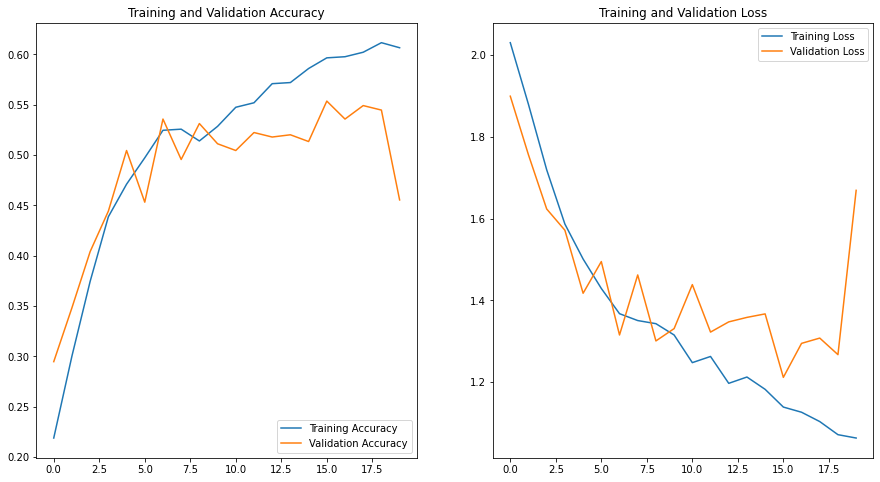

In [22]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

We can now see that the Training Accuracy and Validation Accuracy curves are much closer to each other. This is an improvement over the previous model and we have reduced the overfitting.

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
for class_name in class_names:
    print(class_name, len(list(data_dir_train.glob(f"{class_name}/*.jpg"))))

actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


*seborrheic keratosis* has the least number of samples - 77  
*pigmented benign keratosis* has the highest number of samples - 462


Let us use the  python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
import Augmentor

path_to_training_dataset = "./Data/Train/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to ./Data/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E84D40B610>: 100%|████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 59.67 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ./Data/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E84D481FF0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 55.38 Samples/s]


Initialised with 95 image(s) found.
Output directory set to ./Data/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E8221BE1A0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 65.39 Samples/s]


Initialised with 438 image(s) found.
Output directory set to ./Data/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1E84D0982B0>: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to ./Data/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1E82520F610>: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.66 Samples/s]


Initialised with 462 image(s) found.
Output directory set to ./Data/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E84D256050>: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 113.69 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ./Data/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E84F553A00>: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to ./Data/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E84E8B0B50>: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 127.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to ./Data/Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E82272C850>: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.39 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob("*/output/*.jpg")))
print(image_count_train)

4500


In [27]:
for class_name in class_names:
    print(
        class_name,
        len(list(data_dir_train.glob(f"{class_name}/*.jpg")))
        + len(list(data_dir_train.glob(f"{class_name}/output/*.jpg"))),
    )

actinic keratosis 614
basal cell carcinoma 876
dermatofibroma 595
melanoma 938
nevus 857
pigmented benign keratosis 962
seborrheic keratosis 577
squamous cell carcinoma 681
vascular lesion 639


Lets now move the Augmented output images to the train folder from output folder

In [28]:
for class_name in class_names:
    for file in data_dir_train.glob(f"{class_name}/output/*.jpg"):
        file.rename(data_dir_train.joinpath(class_name, file.name))

In [29]:
# HyperParameters
batch_size = 32
img_height = 180
img_width = 180

In [30]:
train_ds_aug = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 6740 files belonging to 9 classes.
Using 5392 files for training.


In [31]:
val_ds_aug = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 6740 files belonging to 9 classes.
Using 1348 files for validation.


In [32]:
model3 = Sequential(
    [
        layers.Rescaling(scale=1.0 / 255, name="Input_Rescaling"),
        layers.Conv2D(
            filters=16,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv2DH-1",
        ),
        # layers.BatchNormalization(name="BNH-1"),
        layers.MaxPooling2D(name="MaxPoolH-1"),
        layers.Conv2D(
            filters=32,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv2DH-2",
        ),
        # layers.BatchNormalization(name="BNH-2"),
        layers.MaxPooling2D(name="MaxPoolH-2"),
        layers.Conv2D(
            filters=64,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv2DH-3",
        ),
        layers.MaxPooling2D(name="MaxPoolH-3"),
        # layers.BatchNormalization(name="BNH-3"),
        layers.Flatten(name="Flatten-5"),
        layers.Dense(units=128, activation="relu", name="DenseH-6"),
        layers.Dropout(0.2, name="DropOut-4"),
        layers.Dense(units=num_classes, name="Output"),
    ]
)

In [33]:
model3.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [34]:
epochs = 30
history = model3.fit(
    train_ds_aug,
    validation_data=val_ds_aug,
    epochs=epochs,
    # callbacks=[EarlyStopping(monitor="val_loss", patience=10)],
)

Epoch 1/30
169/169 [==============================] - 15s 83ms/step - loss: 1.8845 - accuracy: 0.2791 - val_loss: 1.6091 - val_accuracy: 0.3806
Epoch 2/30
169/169 [==============================] - 15s 84ms/step - loss: 1.5006 - accuracy: 0.4321 - val_loss: 1.3288 - val_accuracy: 0.5022
Epoch 3/30
169/169 [==============================] - 15s 85ms/step - loss: 1.2552 - accuracy: 0.5313 - val_loss: 1.1640 - val_accuracy: 0.5809
Epoch 4/30
169/169 [==============================] - 15s 88ms/step - loss: 1.0816 - accuracy: 0.6033 - val_loss: 1.0827 - val_accuracy: 0.6217
Epoch 5/30
169/169 [==============================] - 16s 90ms/step - loss: 0.9133 - accuracy: 0.6630 - val_loss: 1.1219 - val_accuracy: 0.6135
Epoch 6/30
169/169 [==============================] - 16s 93ms/step - loss: 0.7707 - accuracy: 0.7251 - val_loss: 0.8827 - val_accuracy: 0.6936
Epoch 7/30
169/169 [==============================] - 17s 97ms/step - loss: 0.6279 - accuracy: 0.7776 - val_loss: 0.9786 - val_accuracy:

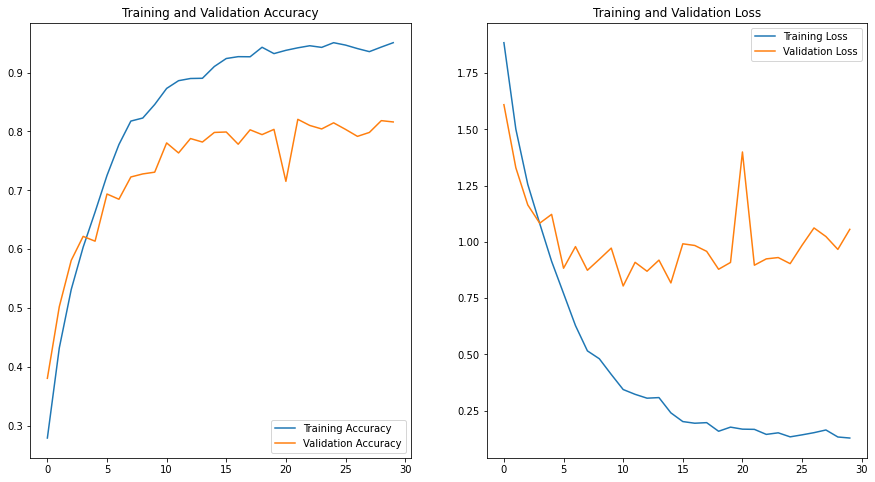

In [35]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

### Evaluate model on Test Data

In [36]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test, seed=123, image_size=(img_height, img_width), batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [37]:
# Evaluate the models on the test data using evaluate

results_1 = model.evaluate(test_ds)
print("Test loss, Test acc:", results_1)

results_2 = model2.evaluate(test_ds)
print("Test loss, Test acc:", results_2)

results_3 = model3.evaluate(test_ds)
print("Test loss, Test acc:", results_3)

4/4 [==============================] - 3s 82ms/step - loss: 4.7403 - accuracy: 0.3051
Test loss, Test acc: [4.7403244972229, 0.3050847351551056]
4/4 [==============================] - 3s 30ms/step - loss: 3.4567 - accuracy: 0.3559
Test loss, Test acc: [3.456716775894165, 0.35593220591545105]
4/4 [==============================] - 3s 45ms/step - loss: 9.1324 - accuracy: 0.3559
Test loss, Test acc: [9.1323881149292, 0.35593220591545105]


In [38]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
for images, labels in test_ds.take(1):
    # output = np.zeros(images.shape[0],1)
    predictions = model3.predict(images)
    output = np.argmax(tf.nn.softmax(predictions), axis=-1)

1/1 [==============================] - 0s 113ms/step


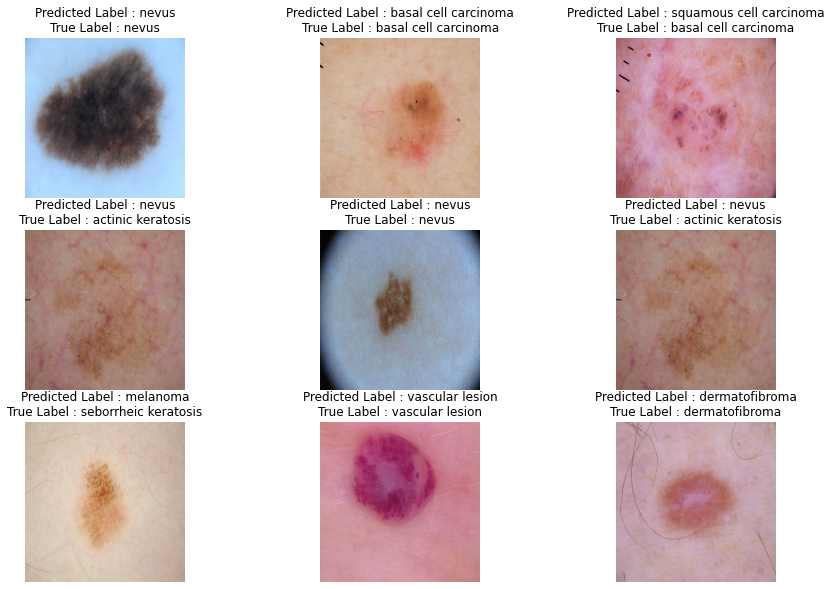

In [39]:
plt.figure(figsize=(15, 10))

pidx = 1
for i in np.random.randint(0, 32, size=9):
    plt.subplot(3, 3, pidx)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(
        f"Predicted Label : {class_names[output[i]]}\nTrue Label : {class_names[labels[i]]}"
    )
    plt.axis("off")
    pidx += 1